In [1]:
import datetime as dt
from functools import reduce

from cycler import cycler
from dateutil.relativedelta import relativedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from numbers import Number
import numpy as np
import pandas as pd
from scipy import stats as sstats
import wmfdata as wmf
from wmfdata.utils import pct_str, sig_figs
from wmfdata.charting import pct_fmt, M_fmt, comma_fmt

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [2]:
%matplotlib inline
wmf.charting.set_mpl_style()

In [3]:
FILE = "metrics/metrics.tsv"
metrics = pd.read_csv(FILE, sep="\t", parse_dates=["month"]).set_index("month")

graph_end = metrics.index[-1]
graph_start = graph_end - relativedelta(months = 47)

# Data transformation

In [4]:
# Transform content flows into content stocks
def stock_to_flow(arr):
    return arr[-1] - arr[0]

flow_cols = [
    "net_new_content_pages", 
    "net_new_Wikipedia_articles", 
    "net_new_Commons_content_pages", 
    "net_new_Wikidata_entities"
]
stock_cols = [
    "content_pages", 
    "Wikipedia_articles", 
    "Commons_content_pages",
    "Wikidata_entities"
]

name_map = {flow_cols[i]: stock_cols[i] for i in range(len(stock_cols))}

stock_metrics = metrics[flow_cols].cumsum().rename(name_map, axis=1)

metrics = pd.concat([metrics, stock_metrics], axis=1)

# Show results
metrics.tail()

,global_south_active_editors,global_south_edits,global_south_nonbot_edits,mobile-heavy_wiki_active_editors,mobile-heavy_wiki_edits,mobile-heavy_wiki_new_editor_retention,mobile-heavy_wiki_nonbot_edits,mobile_edits,net_new_Commons_content_pages,net_new_Wikidata_entities,...,total_edits,uploads,wikidata_edits,active_editors,new_active_editors,returning_active_editors,content_pages,Wikipedia_articles,Commons_content_pages,Wikidata_entities
month,,,,,,,,,,,,,,,,,,,,,
2018-12-01,20359.0,2067577.0,2067577.0,4046.0,1125381.0,0.047045,488735.0,1260737.0,512338.0,947571.0,...,41988394.0,546299.0,21418466.0,80796,14662,66134,199134204.0,49572637.0,51598654.0,53719172.0
2019-01-01,21367.0,2434941.0,2434941.0,4228.0,988233.0,0.043358,512674.0,1416777.0,542425.0,951976.0,...,46312638.0,580719.0,23213770.0,86782,17096,69686,201073142.0,49773003.0,52141079.0,54671148.0
2019-02-01,19743.0,2241877.0,2241875.0,3901.0,966696.0,0.045479,438437.0,1254935.0,494725.0,574002.0,...,44135189.0,531456.0,22667003.0,82554,16335,66219,202528529.0,49968103.0,52635804.0,55245150.0
2019-03-01,21679.0,2294512.0,2294512.0,4252.0,996968.0,0.043950,465084.0,1379133.0,510723.0,643675.0,...,49434627.0,542547.0,28490299.0,87711,17738,69973,204116333.0,50184360.0,53146527.0,55888825.0
2019-04-01,19941.0,2053568.0,2052287.0,3996.0,1412904.0,0.043767,414992.0,1356454.0,584061.0,717420.0,...,51252861.0,616226.0,30126989.0,84358,15535,68823,205898446.0,50452614.0,53730588.0,56606245.0


# Report

In [5]:
report_order = [
    'content_pages', 
        'Wikipedia_articles',
        'Commons_content_pages', 
        'Wikidata_entities',
    'net_new_content_pages',
        'net_new_Wikipedia_articles',
        'net_new_Commons_content_pages',
        'net_new_Wikidata_entities',
    'active_editors',
        'new_active_editors',
        'returning_active_editors',
    'new_editor_retention',
    'revert_rate',
    'total_edits',
        'mobile_edits',
        'wikidata_edits',
        'uploads',
        'other_nonbot_edits',
    # Global South countries
    'global_south_active_editors',
    'global_south_edits',
    'global_south_nonbot_edits',
    # Mobile-heavy wikis
    'mobile-heavy_wiki_active_editors',
    'mobile-heavy_wiki_new_editor_retention',
    'mobile-heavy_wiki_edits',
    'mobile-heavy_wiki_nonbot_edits'
]

In [6]:
def fmt_num(x):
    if isinstance(x, Number) and not pd.isnull(x):
        x = sig_figs(x, 3)
        
        if x < 5:
            return pct_str(x)
        else:
            return "{:,.0f}".format(x)
    else:
        return x

def find_latest(ser):
    nn_ser = ser[~ser.isnull()]
    return nn_ser.index[-1].date()

def calc_rpt(ser):   
    nn_ser = ser[~ser.isnull()]
    cur_mo = nn_ser.index[-1].date()
    cur = nn_ser[-1]
    
    try:
        yr_prev = nn_ser[-13]
        yoy_change = (cur / yr_prev) - 1
    except IndexError:
        yoy_change = None
        
    try:
        cagr = (ser[-12:].mean() / ser[-48:-36].mean())**(1/4) - 1
    except IndexError:
        cagr = None
        
    
    res = [cur_mo, cur, yoy_change, cagr]
    return pd.Series(
        [fmt_num(n) for n in res],
        index=["latest_month", "value", "yoy_change", "4_yr_cagr"]
    )

In [9]:
(
    metrics
    .apply(calc_rpt)
    .transpose()
    .reindex(report_order)
)

,latest_month,value,yoy_change,4_yr_cagr
content_pages,2019-04-01,"206,000,000",12.7%,13.9%
Wikipedia_articles,2019-04-01,"50,500,000",5.1%,7.4%
Commons_content_pages,2019-04-01,"53,700,000",15.5%,15.1%
Wikidata_entities,2019-04-01,"56,600,000",20.6%,29.6%
net_new_content_pages,2019-04-01,"1,780,000",-17.0%,5.9%
net_new_Wikipedia_articles,2019-04-01,"268,000",55.4%,-14.1%
net_new_Commons_content_pages,2019-04-01,"584,000",-0.3%,5.6%
net_new_Wikidata_entities,2019-04-01,"717,000",-37.1%,27.3%
active_editors,2019-04-01,"84,400",1.2%,0.1%
new_active_editors,2019-04-01,"15,500",-2.5%,-3.6%


# Graphs

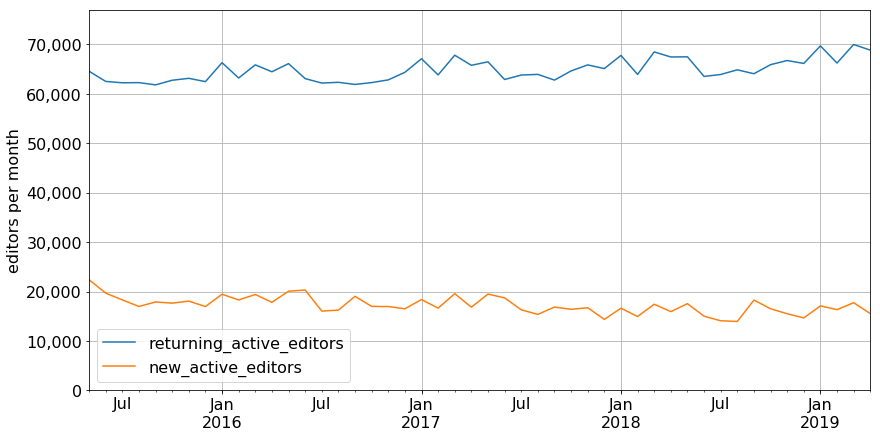

In [10]:
ax = metrics[["returning_active_editors", "new_active_editors"]][graph_start:graph_end].plot()
plt.gca().yaxis.set_major_formatter(comma_fmt)
y_top = plt.ylim()[1] * 1.1
plt.ylim(bottom=0, top=y_top)
plt.xlabel("")
plt.ylabel("editors per month");

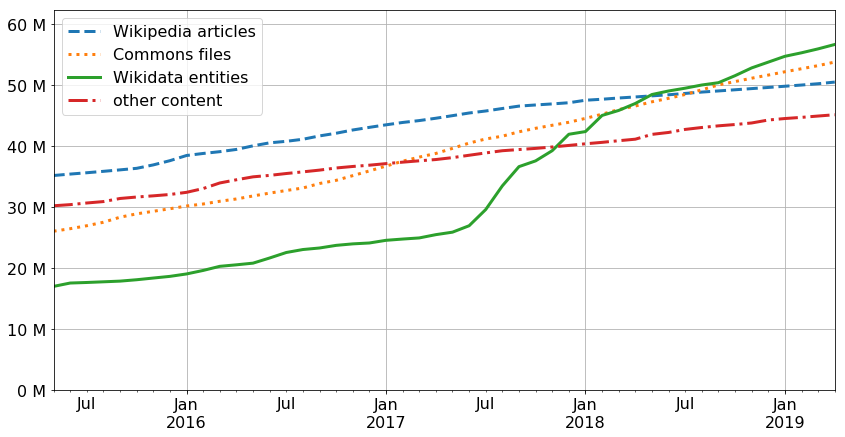

In [11]:
custom_cyc = cycler('color', ['r', 'g', 'b', 'y']) + cycler('linestyle', ['-', '--', ':', '-.'])
content_types = metrics[["Wikipedia_articles", "Commons_content_pages", "Wikidata_entities"]]
content_ser = [tup[1] for tup in content_types.iteritems()]

other_content = reduce(lambda x, y: x - y, content_ser, metrics["content_pages"]).rename("other_content")
content = pd.concat(
    [content_types, other_content], 
    axis=1
).rename(
    columns=lambda name: name.replace("_", " ")
).rename(
    columns={"Commons content pages": "Commons files"}
)

ax.set_prop_cycle(custom_cyc)
ax = content[graph_start:graph_end].plot(style=['--', ':', '-', '-.'], linewidth=3)

ax.yaxis.set_major_formatter(M_fmt)
y_top = plt.ylim()[1] * 1.1
plt.ylim(bottom=0, top=y_top)
plt.xlabel("")
plt.ylabel("");


content pages


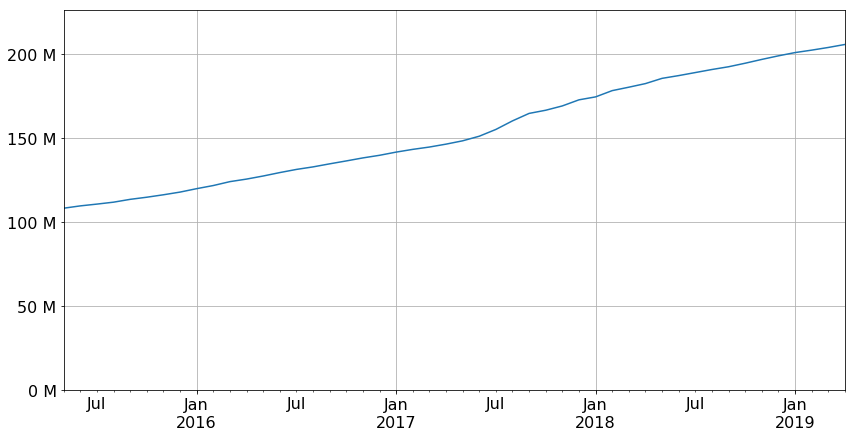

Wikipedia articles


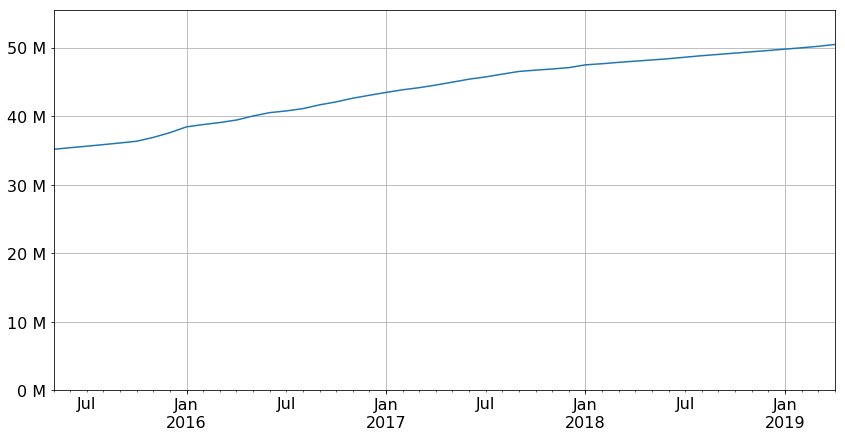

Commons content pages


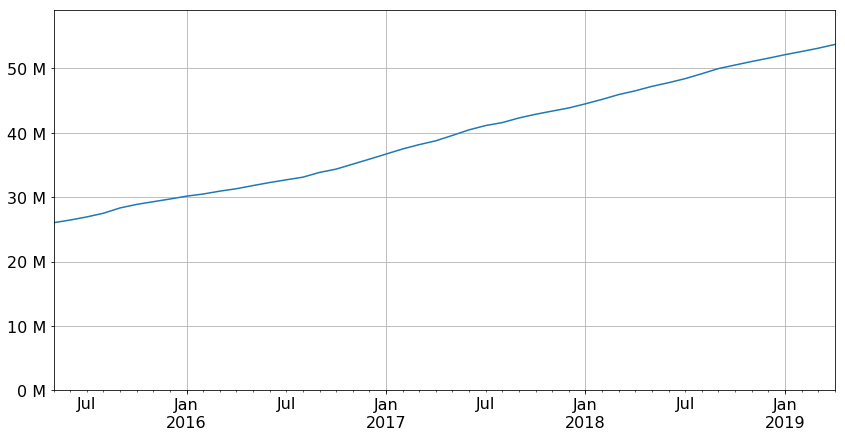

Wikidata entities


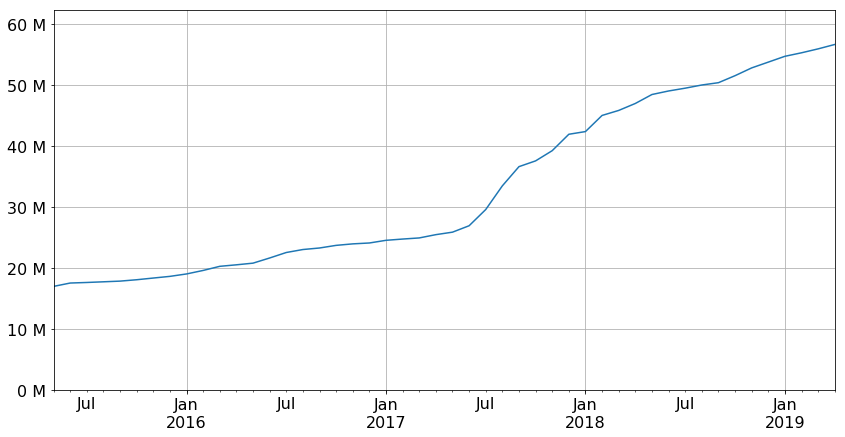

net new content (main namespace pages + files)


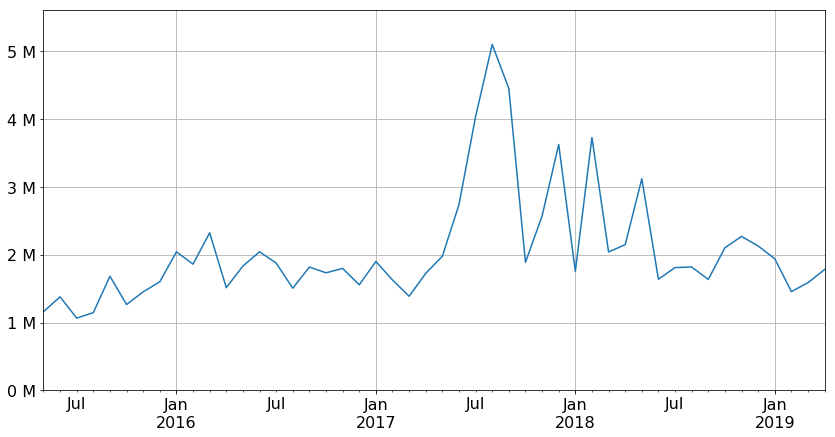

net new Wikipedia articles


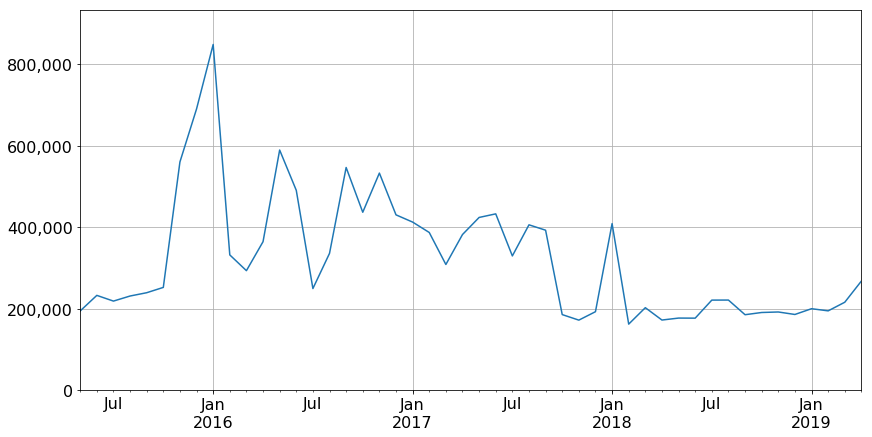

net new files on all projects


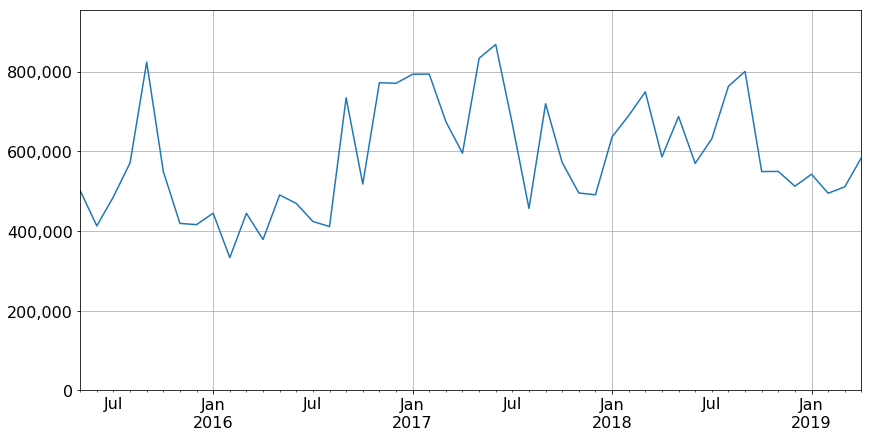

net new Wikidata entities


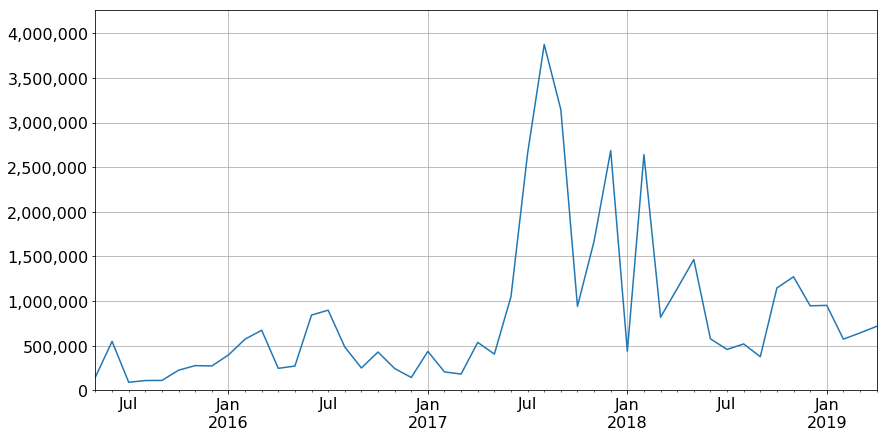

active editors


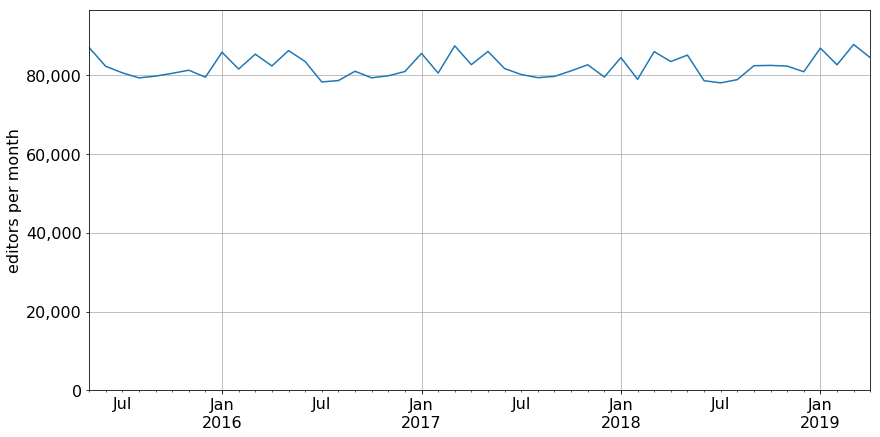

new active editors


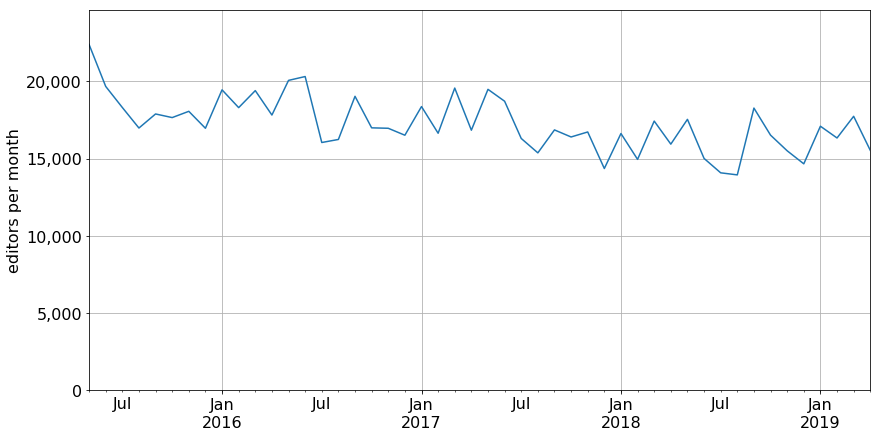

returning active editors


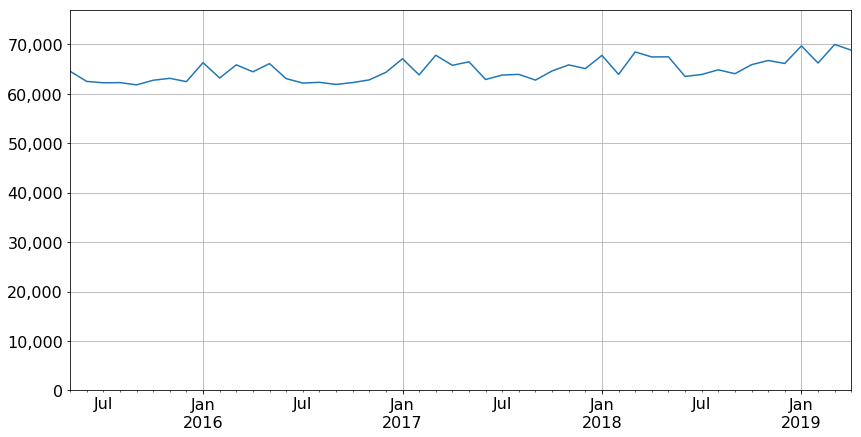

new editor retention


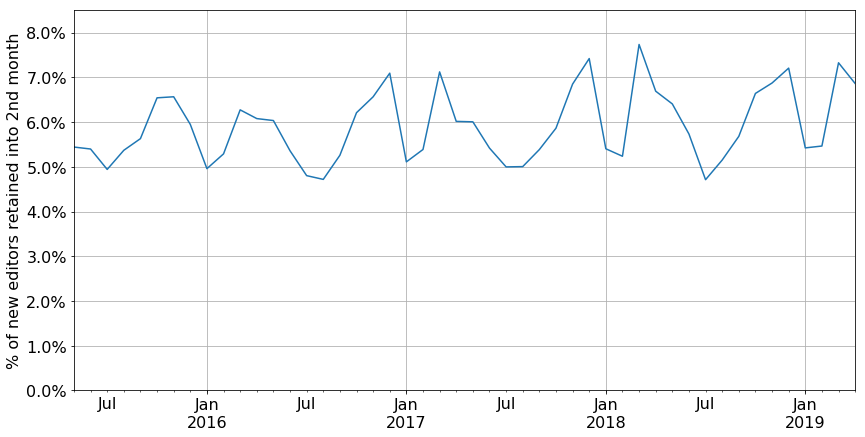

revert rate


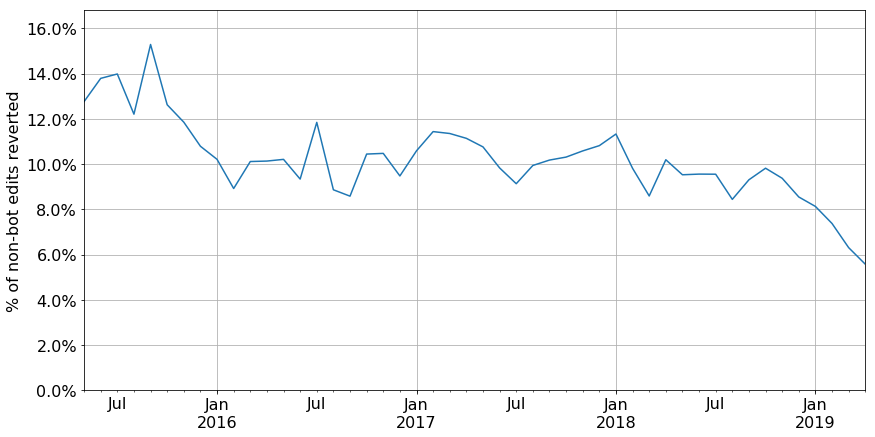

total edits


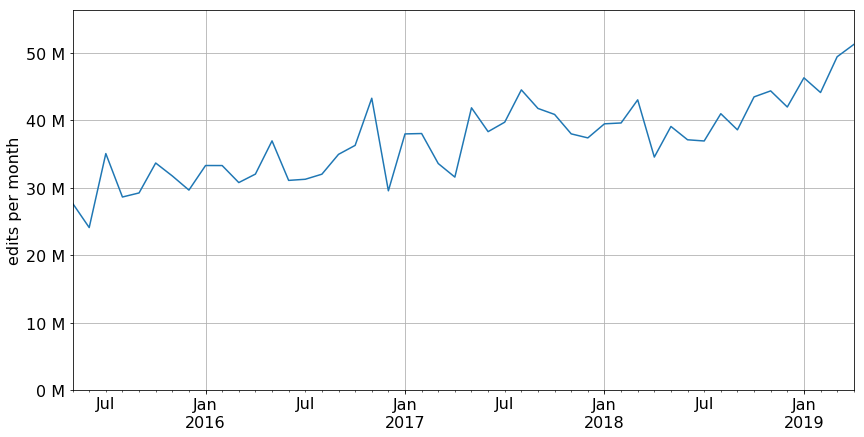

mobile edits


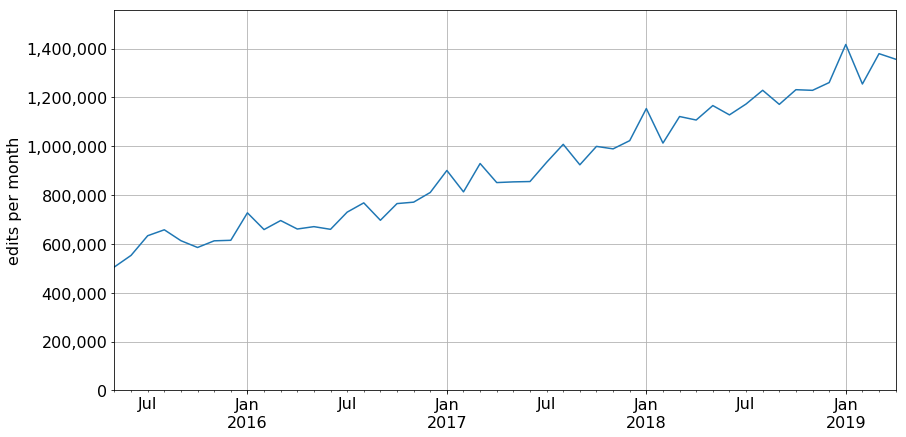

wikidata edits


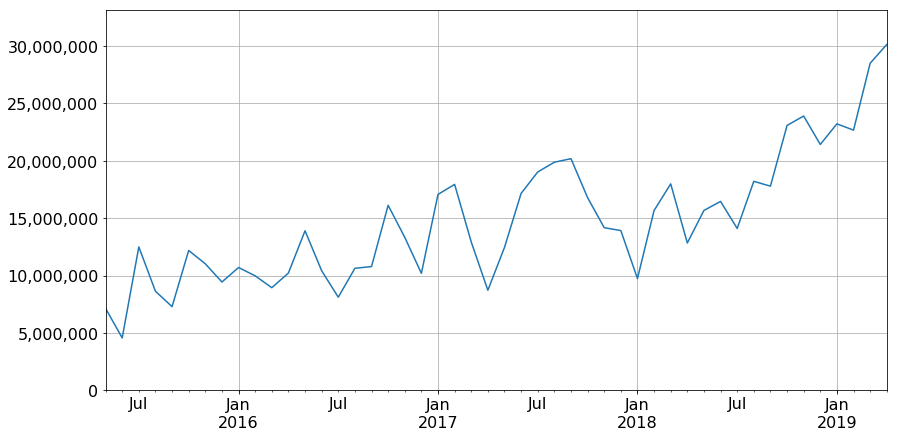

uploads


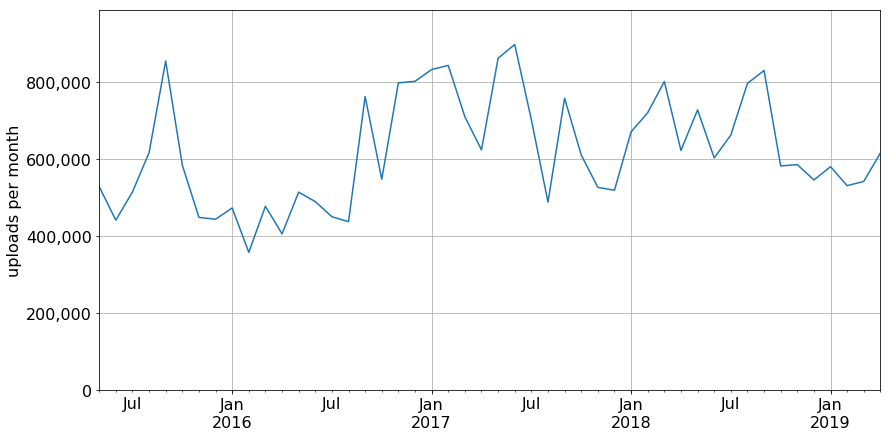

nonbot edits, excluding data and upload edits


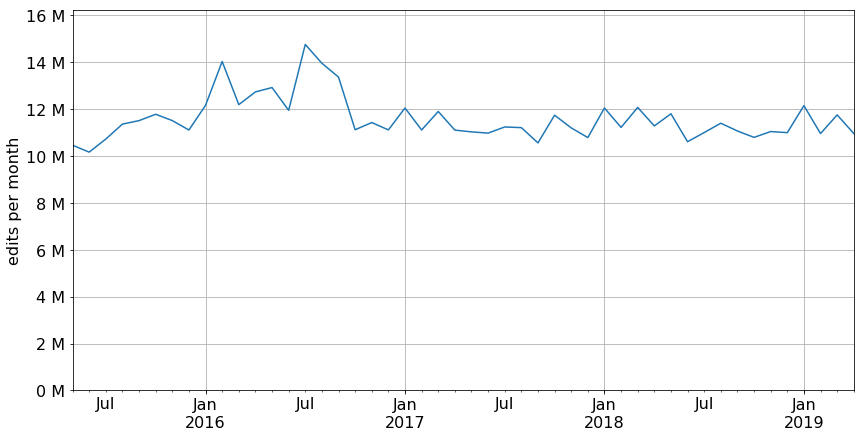

global south active editors


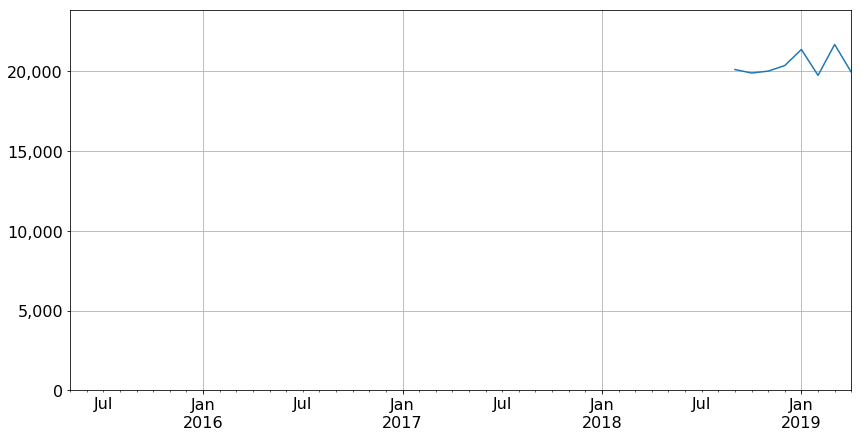

global south edits


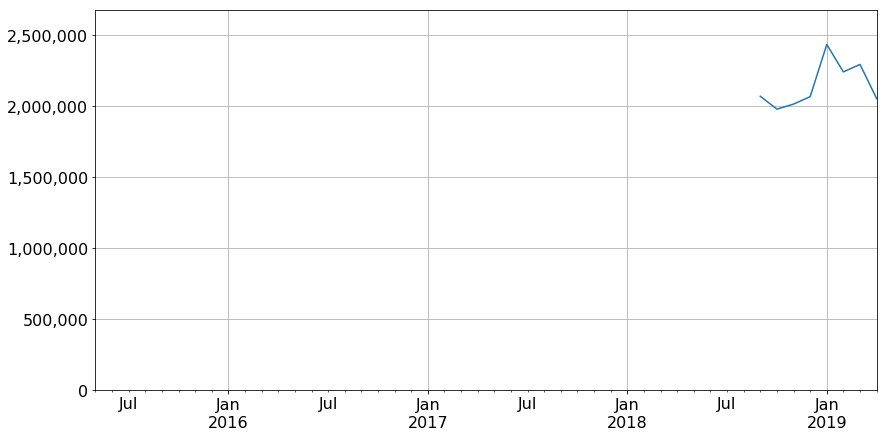

global south nonbot edits


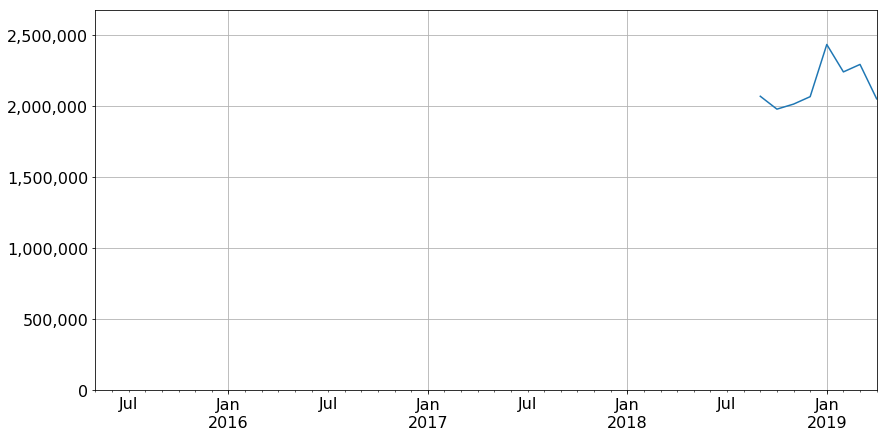

mobile-heavy wiki active editors


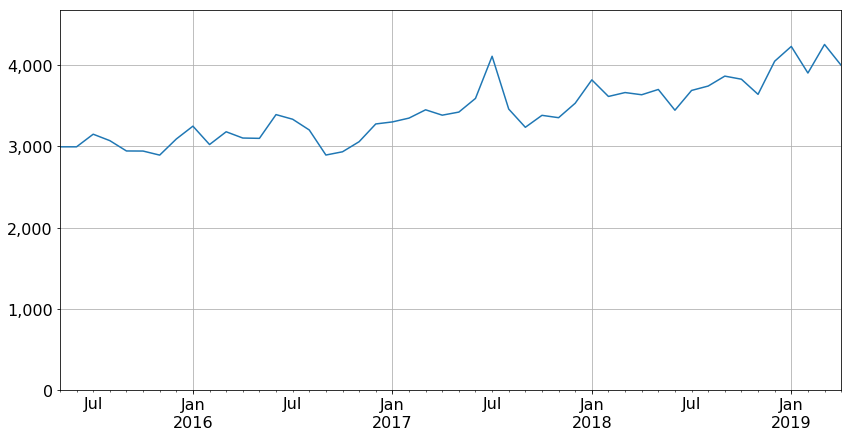

mobile-heavy wiki new editor retention


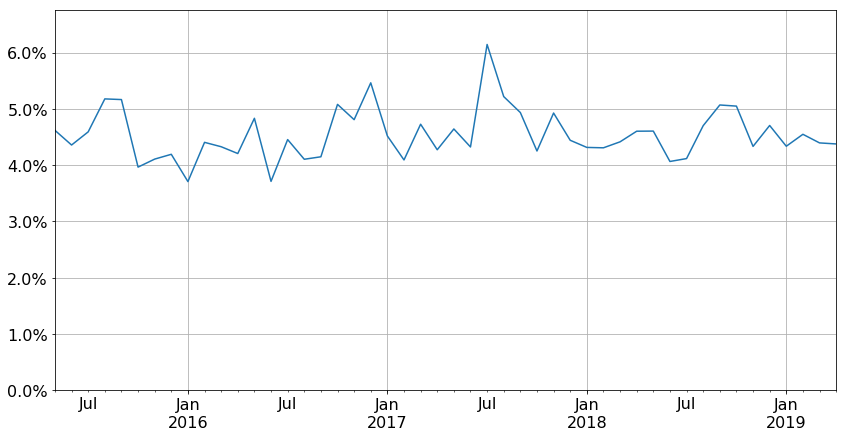

mobile-heavy wiki edits


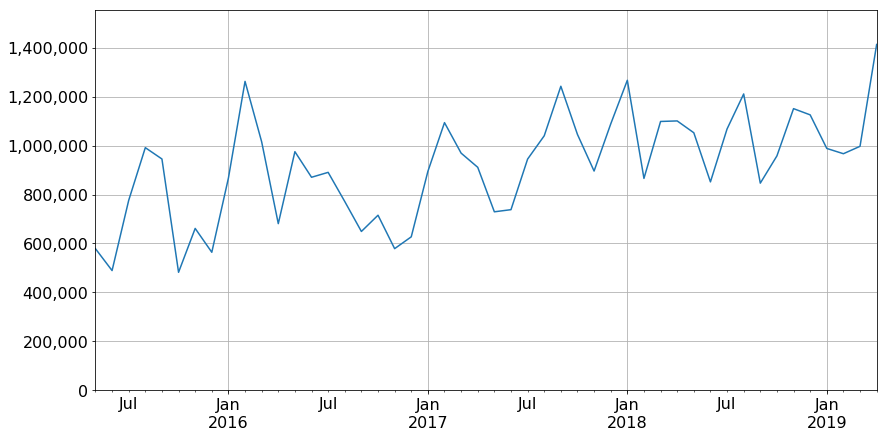

mobile-heavy wiki nonbot edits


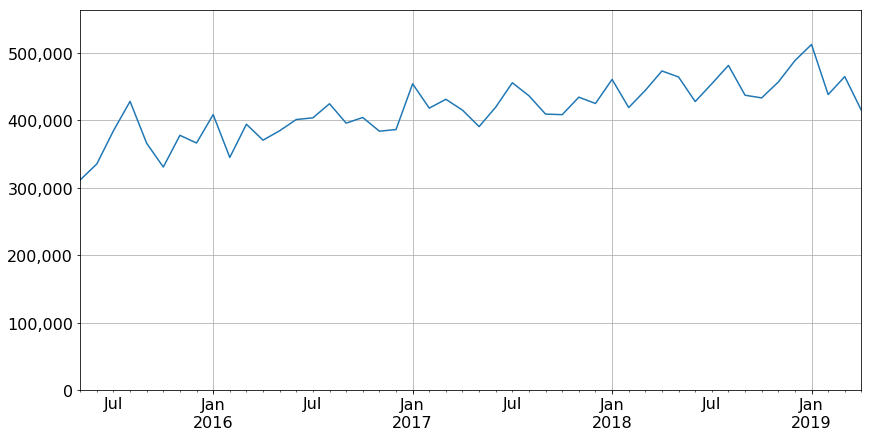

In [12]:
graph_cfg = {
    "active_editors": {
        "y_lab": "editors per month"
    },
    "content_pages": {
        "y_fmt": M_fmt,
    },
    "Wikipedia_articles": {
        "y_fmt": M_fmt,
    },
    "Wikidata_entities": {
        "y_fmt": M_fmt,
    },
    "Commons_content_pages": {
        "y_fmt": M_fmt,
    },
    "existing_active_editors": {
        "y_lab": "editors per month"
    },
    "new_active_editors": {
        "y_lab": "editors per month"
    },
    "second_month_active_editors": {
        "y_lab": "editors per month"
    },
    "total_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "mobile-heavy_wiki_new_editor_retention": {
        "y_fmt": pct_fmt
    },
    "mobile_edits": {
        "y_lab": "edits per month"
    },
    "other_nonbot_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month",
        "title": "nonbot edits, excluding data and upload edits"
    },
    "new_editor_retention": {
        "y_fmt": pct_fmt,
        "y_lab": "% of new editors retained into 2nd month"
    },
    "revert_rate": {
        "y_fmt": pct_fmt,
        "y_lab": "% of non-bot edits reverted"
    },
    "uploads": {
        "y_lab": "uploads per month"
    },
    "data_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "net_new_content_pages": {
        "y_fmt": M_fmt,
        "title": "net new content (main namespace pages + files)"
    },
    "net_new_Wikipedia_articles": {
    },
    "net_new_Commons_content_pages": {
        "title": "net new files on all projects"
    },
    "net_new_Wikidata_entities": {
    }
}

for name, col in metrics.reindex(report_order, axis=1).iteritems():
    cfg = graph_cfg.get(name, {})
    plt.figure()
    
    col[graph_start:graph_end].plot()

    print(cfg.get("title", name.replace("_", " ")))
    # plt.title(cfg.get("title", name.replace("_", " ")))
    plt.ylabel(cfg.get("y_lab", ""))
    plt.xlabel("")
    plt.gca().yaxis.set_major_formatter(cfg.get("y_fmt", comma_fmt))
    
    y_top = plt.ylim()[1] * 1.1
    plt.ylim(bottom=0, top=y_top)
    plt.show()
    plt.close()